# Molecular Descriptor

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import emoji
# %matplotlib inline 

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#from utility import FeatureGenerator
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

#importing sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import pandas as pd
from mordred import Calculator, descriptors
import wget
import unzip
import padelpy

In [ ]:
import os
import requests
from urllib.parse import urlparse

# URLs of the raw CSV files on GitHub
urls = [
    "https://raw.githubusercontent.com/arashtayyebi/prediction-of-water-solubility/main/new222new.csv",
    "https://raw.githubusercontent.com/arashtayyebi/prediction-of-water-solubility/main/testexperiment2upload2raw.csv",
    "https://raw.githubusercontent.com/arashtayyebi/prediction-of-water-solubility/main/testexperiment2upload3raw.csv"
]

# Create a folder to store downloaded files if it doesn't exist
folder_name = "water_solubility_dataset"
os.makedirs(folder_name, exist_ok=True)

# Loop through each URL and download the file
for url in urls:
    # Parse the URL to extract the file name
    parsed_url = urlparse(url)
    file_name = os.path.join(folder_name, os.path.basename(parsed_url.path))

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Save the content of the response (CSV data) to a local file
        with open(file_name, "wb") as file:
            file.write(response.content)
        print(f"File '{file_name}' downloaded successfully.")
    else:
        print(f"Failed to download the file from '{url}'.")



File 'water_solubility_dataset/new222new.csv' downloaded successfully.
File 'water_solubility_dataset/testexperiment2upload2raw.csv' downloaded successfully.


In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd

sol = pd.read_csv('water_solubility_dataset/new222new.csv')
print(sol.head)
XY = sol.set_index('SMILES').T.to_dict('list')
# print(XY)

<bound method NDFrame.head of                                                  SMILES  \
0               OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O   
1     O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...   
2     OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...   
3                CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2   
4                          CN1CC2CC(C1)C1=CC=CC(=O)N1C2   
...                                                 ...   
8433                                      O=[N+]([O-])C   
8434                                                 OC   
8435                                            S=C(N)N   
8436                                           O=C(NO)N   
8437                                            O=C(N)N   

      measured log(solubility:mol/L)  
0                               0.79  
1                               0.79  
2                               0.79  
3                               0.65  
4                               0.65  
...                        

In [3]:
Y = sol.iloc[:,1] # index 1 = log(solubility:mol/L)
Y

0       0.79
1       0.79
2       0.79
3       0.65
4       0.65
        ... 
8433    0.26
8434    1.57
8435    0.32
8436    1.12
8437    0.96
Name: measured log(solubility:mol/L), Length: 8438, dtype: float64

In [4]:
#descriptor
molecules = sol.SMILES.apply(Chem.MolFromSmiles)

def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

mordred_descriptors = All_Mordred_descriptors(sol['SMILES'])

100%|███████████████████████████████████████████████████████████████████████████████| 8438/8438 [01:53<00:00, 74.16it/s]


In [5]:
mordred_descriptors.shape

(8438, 1613)

In [6]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold()

X=mordred_descriptors
des_num = X.select_dtypes(include='number')
des_num.shape

(8438, 809)

In [7]:
transformed = vt.fit_transform(des_num)

_ = vt.fit(des_num)

mask = vt.get_support()

des_num = des_num.loc[:, mask]

vt = VarianceThreshold(threshold=0.1)

# Fit
_ = vt.fit(des_num)

# Get the boolean mask
mask = vt.get_support()

des_reduced = des_num.loc[:, mask]
H=des_reduced
#X=H.drop(['FilterItLogS', 'SLogP'], axis=1)
X=H
X.shape

(8438, 504)

In [8]:
correlated_features = set()
correlation_matrix=X.corr()

In [9]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print(len(correlated_features))
print(correlated_features)

328
{'CIC3', 'ATSC0se', 'ATS4i', 'MIC1', 'AATS1d', 'SaaCH', 'ATSC0are', 'naRing', 'fragCpx', 'TIC2', 'CIC5', 'AATS1Z', 'AATS0are', 'TIC4', 'Xc-3d', 'ATSC5pe', 'ATS6dv', 'AATS0m', 'ATSC0m', 'ATS2dv', 'MPC3', 'ZMIC5', 'ATS4m', 'ATS1d', 'ATS8v', 'SssCH2', 'nBondsKD', 'TopoPSA(NO)', 'MWC01', 'CIC0', 'MPC10', 'nBondsO', 'ATS5pe', 'VMcGowan', 'Xpc-6dv', 'MWC09', 'ATS4v', 'MW', 'ATSC2pe', 'ATS4pe', 'nBondsM', 'ATS2m', 'SaasN', 'NaaCH', 'Xp-5dv', 'AATSC1dv', 'ATS3d', 'ATSC0dv', 'SddssS', 'AATS0pe', 'ATS7se', 'ATS1are', 'ATS4p', 'Xpc-6d', 'Sp', 'SMR_VSA1', 'WPath', 'ATSC1are', 'MWC08', 'MPC4', 'SZ', 'SsNH2', 'ATS7d', 'piPC7', 'ATS6se', 'AATSC0m', 'ATS1se', 'MIC5', 'SRW10', 'ATSC4pe', 'ATSC7pe', 'ATS8pe', 'SlogP_VSA5', 'ATSC8se', 'AATS1p', 'ATS6are', 'ATSC3pe', 'Xp-6dv', 'apol', 'MWC10', 'ATS5Z', 'AATS0p', 'ATS0i', 'AATSC0Z', 'piPC6', 'IC2', 'ATS7are', 'ATS1v', 'EState_VSA10', 'ATS8i', 'SddsN', 'ATS3dv', 'SsBr', 'ATS1i', 'ATS7Z', 'MIC3', 'n5aHRing', 'TIC5', 'TIC0', 'SlogP_VSA8', 'ATS5d', 'SRW05'

In [10]:
X.drop(labels=correlated_features, axis=1, inplace=True)

/tmp/ipykernel_18222/1003493426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(labels=correlated_features, axis=1, inplace=True)


In [11]:
X.shape

(8438, 176)

In [12]:
X.head()

,nAcid,nBase,nAromAtom,nAtom,nHeavyAtom,nBridgehead,nHetero,nC,nN,nO,...,n5HRing,n6HRing,n5aRing,naHRing,nARing,n5ARing,n6ARing,nAHRing,nFRing,nRot
0,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
1,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
2,0,0,0,45,23,0,11,12,0,11,...,1,1,0,0,2,1,1,2,0,5
3,0,1,6,31,15,2,3,12,2,1,...,0,3,0,1,2,0,2,2,1,0
4,0,1,6,31,15,2,3,12,2,1,...,0,3,0,1,2,0,2,2,1,0


In [13]:
gf=set()
i=0
for i in range(len(X.columns)):
   
    colname = X.columns[i]
    gf.add(colname)
gf

{'AATS0d',
 'AATS0dv',
 'AATS0i',
 'AATSC0dv',
 'AATSC0i',
 'AATSC0v',
 'AATSC1Z',
 'ATS0Z',
 'ATSC0i',
 'ATSC1Z',
 'ATSC1d',
 'ATSC1dv',
 'ATSC1i',
 'ATSC1p',
 'ATSC1se',
 'ATSC1v',
 'ATSC2Z',
 'ATSC2d',
 'ATSC2dv',
 'ATSC2i',
 'ATSC2se',
 'ATSC2v',
 'ATSC3Z',
 'ATSC3d',
 'ATSC3dv',
 'ATSC3i',
 'ATSC3p',
 'ATSC3se',
 'ATSC3v',
 'ATSC4Z',
 'ATSC4d',
 'ATSC4dv',
 'ATSC4i',
 'ATSC4p',
 'ATSC4se',
 'ATSC4v',
 'ATSC5Z',
 'ATSC5d',
 'ATSC5dv',
 'ATSC5i',
 'ATSC5p',
 'ATSC5se',
 'ATSC5v',
 'ATSC6Z',
 'ATSC6d',
 'ATSC6dv',
 'ATSC6i',
 'ATSC6se',
 'ATSC6v',
 'ATSC7Z',
 'ATSC7d',
 'ATSC7dv',
 'ATSC7i',
 'ATSC7p',
 'ATSC7v',
 'ATSC8Z',
 'ATSC8d',
 'ATSC8dv',
 'ATSC8i',
 'ATSC8v',
 'BalabanJ',
 'C1SP2',
 'C1SP3',
 'C2SP3',
 'C3SP2',
 'C3SP3',
 'CIC1',
 'ECIndex',
 'EState_VSA1',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'FilterItLogS',
 'GATS1i',
 'GATS1p',
 'IC1',
 'NaaN',
 'NaaNH',
 'NaaaC',
 'NaasC',
 'NaasN',
 'NddsN',
 'N

In [14]:
#data split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=991)
#test size is 20% and traing size is 80%
#linear regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## LinearRegression

In [15]:
%%time

reg = LinearRegression()
reg.fit(X, Y)

CPU times: user 309 ms, sys: 1.86 ms, total: 311 ms
Wall time: 55.7 ms


LinearRegression()

In [16]:
#predicts the X_train
Y_pred_train = reg.predict(X_train)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.82
Coefficient of determination (R^2): 0.80


In [17]:
#predicts the X_test
Y_pred_test = reg.predict(X_test)
#print('Coefficients:', model.coef_)44444444444
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.80
Coefficient of determination (R^2): 0.82


In [18]:
from sklearn.metrics import mean_absolute_error
mae_test = mean_absolute_error(Y_test, Y_pred_test)
mae_train = mean_absolute_error(Y_train, Y_pred_train)
print(mae_test, mae_train)


0.6100716809611205 0.6186673455132468


In [19]:
residuals= Y_train - Y_pred_train

mse=np.mean(residuals**2)
RMSE = np.sqrt(mse)
RMSE

0.823467058133871

In [20]:
n=len(Y_train)
p=X.shape[1]
print(p)
SEE=np.sqrt(mse*(n-p-1)/n)
SEE

176


0.8125987690714963

In [21]:
SEP = SEE * np.sqrt(1 + 1/n)
SEP

0.8126589593437223

In [22]:
# Calculate the residuals
residuals_test = Y_test - Y_pred_test

# Calculate the mean of the residuals for the test set
mean_residuals_test = np.mean(residuals_test)

# Calculate the standard deviation of the residuals for the test set
std_residuals_test = np.std(residuals_test, ddof=1)

# Calculate the standard error of prediction (SEP) for the test set
SEP = std_residuals_test * np.sqrt(1 + 1/len(X_test))

SEE=SEP*(1/(np.sqrt(1 + 1/(len(X_test)))))
SEE
# Calculate the standard error of estimate (SEE) for the training set
print("Standard error of prediction on test set: {:.2f}".format(SEP))
print("Standard error of estimate on training set: {:.2f}".format(SEE))

Standard error of prediction on test set: 0.80
Standard error of estimate on training set: 0.80


In [23]:
# import shap
# from sklearn.preprocessing import StandardScaler
# import os
# import sys
# #import Explanation

In [24]:
# %%time

# explainer = shap.Explainer(reg)
# shap_values = explainer(X_test)

## Random Forest Regressor

In [25]:
%%time

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

CPU times: user 47.1 s, sys: 87.8 ms, total: 47.2 s
Wall time: 46.3 s


RandomForestRegressor(random_state=42)

In [26]:
#predicts the X_train
Y_pred_train = model.predict(X_train)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (RMSE): 0.26
Coefficient of determination (R^2): 0.98


In [27]:
Y_pred_test = model.predict(X_test)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.66
Coefficient of determination (R^2): 0.88


In [28]:
mae_test = mean_absolute_error(Y_test, Y_pred_test)
mae_train = mean_absolute_error(Y_train, Y_pred_train)
print(mae_test, mae_train)

0.43132808579348064 0.16959978811293822


In [29]:
residuals= Y_train - Y_pred_train

In [30]:
mse=np.mean(residuals**2)
RMSE = np.sqrt(mse)
RMSE

0.25846937846283746

In [31]:
n=len(Y_train)
p=X.shape[1]
SEE=np.sqrt(mse*(n-p-1)/n)
SEE

0.25505804598613535

In [32]:
SEP = SEE * np.sqrt(1 + 1/n)
SEP

0.25507693847503105

In [33]:
# Calculate the residuals
residuals_test = Y_test - Y_pred_test

# Calculate the mean of the residuals for the test set
mean_residuals_test = np.mean(residuals_test)

# Calculate the standard deviation of the residuals for the test set
std_residuals_test = np.std(residuals_test, ddof=1)

# Calculate the standard error of prediction (SEP) for the test set
SEP = std_residuals_test * np.sqrt(1 + 1/len(X_test))

SEE=SEP*(1/(np.sqrt(1 + 1/(len(X_test)))))
SEE
# Calculate the standard error of estimate (SEE) for the training set
print("Standard error of prediction on test set: {:.2f}".format(SEP))
print("Standard error of estimate on training set: {:.2f}".format(SEE))

Standard error of prediction on test set: 0.66
Standard error of estimate on training set: 0.66


In [34]:
import shap
from sklearn.preprocessing import StandardScaler
import os
import sys
#import Explanation

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [35]:
%%time

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

CPU times: user 5min 23s, sys: 556 ms, total: 5min 24s
Wall time: 5min 23s


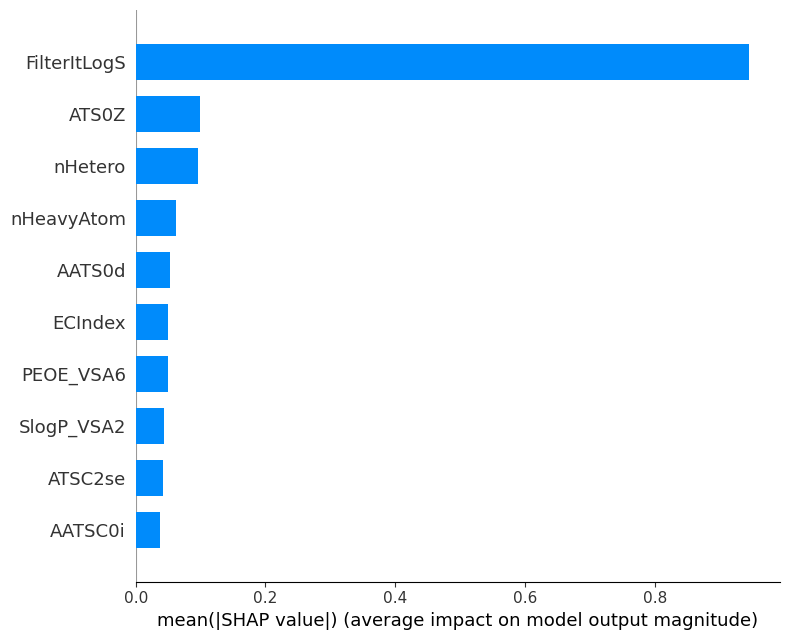

In [36]:
shap.summary_plot(shap_values, X_test, plot_type="bar",show=False,max_display=10,plot_size=0.5)

#plot_size=(18.0, 10.0)
plt.savefig('most effective descriptor for des approch with SLOGP.pdf',bbox_inches='tight',dpi = 1000)

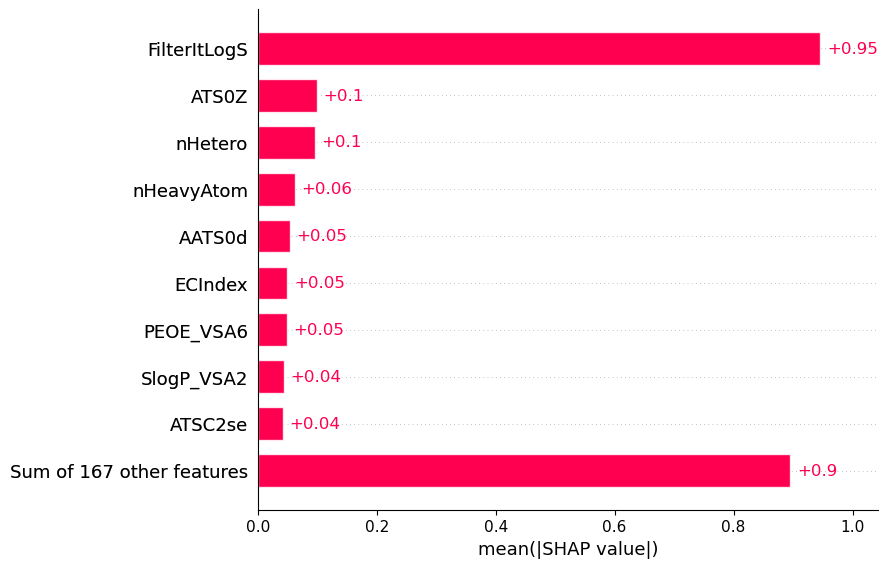

In [37]:
shap.plots.bar(shap_values, max_display=10,show=False)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

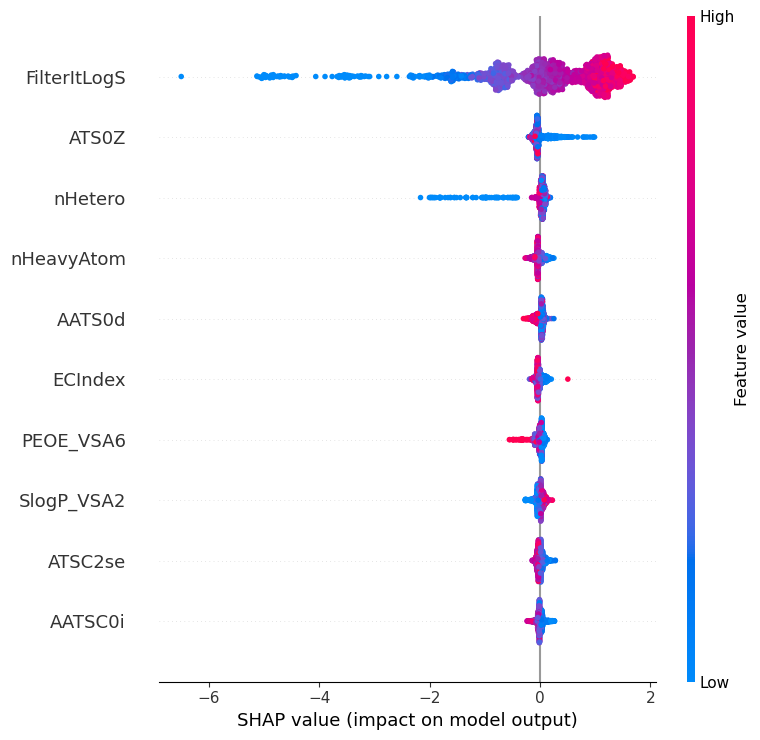

In [38]:
shap.summary_plot(shap_values, plot_type="dot", plot_size=0.6, show=False,max_display=10)
plt.savefig('scratcch.pdf',bbox_inches='tight',dpi = 1000)

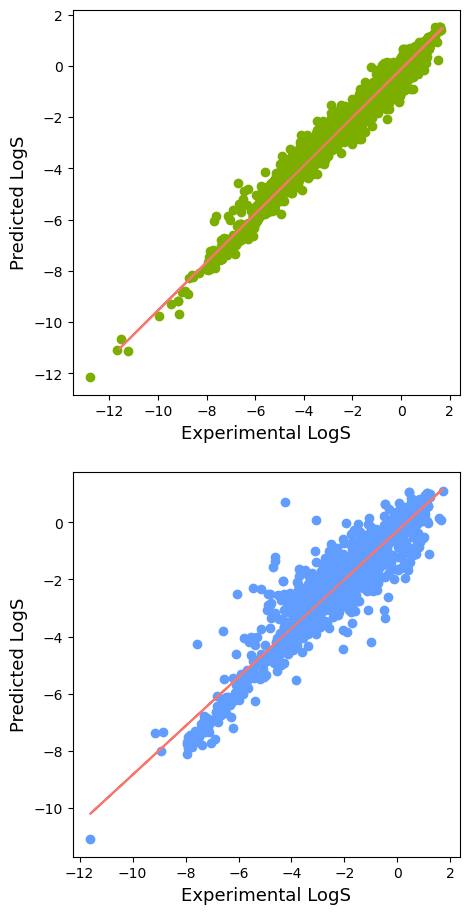

In [39]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")


plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

plt.savefig('plot_vertical_logS.png')
plt.savefig('paper logS descriptor.pdf',dpi=1200)
plt.show()

## Blind test of LinearRegression and Random forest Regressor

In [40]:
testdata_1 = pd.read_csv('water_solubility_dataset/testexperiment2upload2raw.csv')
testdata_1

,name,SMILES
0,Acebutolol,CC(C)NCC(O)COC1=C(C(C)=O)C=C(NC(CCC)=O)C=C1
1,Amoxicillin,O=C(O)[C@H]1C(C)(C)S[C@@H](N21)[C@H](NC([C@@H]...
2,Bendroflumethiazide,O=S1(C2=CC(S(N)(=O)=O)=C(C(F)(F)F)C=C2NC(CC3=C...
3,Benzocaine,NC1=CC=C(C(OCC)=O)C=C1
4,Benzthiazide,O=S1(C2=CC(S(N)(=O)=O)=C(Cl)C=C2N=C(CSCC3=CC=C...
5,2-chloromandelic_acid,OC(C(O)C1=CC=CC=C1Cl)=O
6,Clozapine,ClC(C=C1)=CC2=C1NC(C=CC=C3)=C3C(N4CCN(C)CC4)=N2
7,Dibucaine,CCN(CC)CCNC(C1=C(C=CC=C2)C2=NC(OCCCC)=C1)=O
8,Diethylstilbestrol,CC/C(C1=CC=C(O)C=C1)=C(C2=CC=C(O)C=C2)/CC
9,Diflunisal,FC(C=C1F)=CC=C1C2=CC=C(O)C(C(O)=O)=C2


In [41]:
testdata_2 = pd.read_csv('water_solubility_dataset/testexperiment2upload3raw.csv')
testdata_2

,Substance,SMILES
0,hexobarbital,CN1C(=O)NC(=O)C(C)(C1=O)C1=CCCCC1
1,nalidixic_acid,CCn1cc(c(=O)c2ccc(nc12)C)C(=O)O
2,phenantroline,c12c(ccc3cccnc13)cccn2
3,phenobarbital,C1(NC(C(c2ccccc2)(C(=O)N1)CC)=O)=O
4,sulfamethazine,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1
5,bromogramine,Brc1cc2c(CN(C)C)c[nH]c2cc1
6,phenazopyridine,c1ccc(cc1)\N=N\c1c(nc(cc1)N)N
7,amantadine,C1C2CC3CC(CC1C3)(N)C2
8,benzylimidazole,n1(Cc2ccccc2)cncc1
9,chlorpropamide,Clc1ccc(S(=O)(NC(=O)NCCC)=O)cc1


In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

mordred_descriptors1 = All_Mordred_descriptors(testdata_1['SMILES'])
mordred_descriptors2 = All_Mordred_descriptors(testdata_2['SMILES'])

Xnew_1=mordred_descriptors1

print(Xnew_1.shape)

Xnew_2=mordred_descriptors2

print(Xnew_2.shape)

  6%|█████▎                                                                              | 2/32 [00:00<00:09,  3.14it/s]

In [ ]:
ynew_LR_1 = reg.predict(Xnew_1)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
print(ynew_LR_1)

ynew_RF_1 = reg.predict(Xnew_1)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
print(ynew_RF_1)

ynew_LR_2 = reg.predict(Xnew_2)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
print(ynew_LR_1)

ynew_RF_2 = reg.predict(Xnew_2)
#print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))
print(ynew_RF_2)

In [ ]:
# from numpy import asarray
# from numpy import savetxt
# # define data
# data = asarray(y2new)
# # save to csv file
# savetxt('dataggg.csv', data, delimiter=',')